# 1. Data Loading & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

!pip install scikit-surprise

In [2]:
# Load dataset

file_path = "OnlineRetail.xlsx" 
df = pd.read_excel(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Drop missing CustomerID and filter Quantity and UnitPrice > 0

df.dropna(subset=['CustomerID'], inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [7]:
# Convert InvoiceDate to datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,InvoiceYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010


# 2. Exploratory Data Analysis (EDA)

In [8]:
print("Unique Customers:", df['CustomerID'].nunique())
print("Unique Products:", df['StockCode'].nunique())
print("Total Transactions:", df['InvoiceNo'].nunique())

Unique Customers: 4338
Unique Products: 3665
Total Transactions: 18532


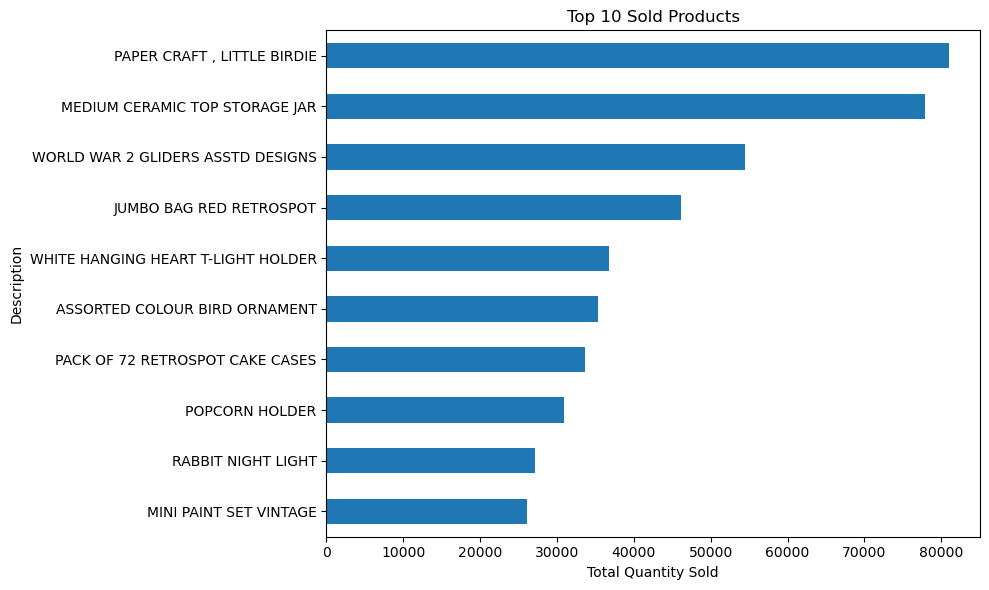

In [9]:
# Top 10 most sold products

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10,6), title='Top 10 Sold Products')
plt.gca().invert_yaxis()
plt.xlabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

# 3. Preprocessing for Recommendation

In [10]:
# Create user-item matrix using Quantity * UnitPrice as value (total spend)

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
user_item_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='TotalPrice', aggfunc='sum', fill_value=0)
user_item_matrix

# 4. Model Building - Collaborative Filtering

In [12]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split

# Convert user-item matrix to Surprise dataset

ratings_df = df[['CustomerID', 'StockCode', 'TotalPrice']].copy()
ratings_df['CustomerID'] = ratings_df['CustomerID'].astype(str)
ratings_df['StockCode'] = ratings_df['StockCode'].astype(str)

reader = Reader(rating_scale=(0, ratings_df['TotalPrice'].max()))
data = Dataset.load_from_df(ratings_df[['CustomerID', 'StockCode', 'TotalPrice']], reader)

In [13]:
# Train-Test split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model

model = SVD()
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
model.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    168446.1745168448.1478168447.6690168447.9525168447.4890168447.48650.6941  
MAE (testset)     168444.8738168448.1298168447.6547168447.9392168447.4175168447.20301.1896  
Fit time          4.49    4.57    4.43    4.44    4.54    4.49    0.05    
Test time         0.71    0.65    0.78    0.79    0.91    0.77    0.09    


# 5. Generating Recommendations

In [14]:
def get_recommendations(customer_id, N=10, method="CF"):
    customer_id = str(customer_id)
    purchased = set(ratings_df[ratings_df['CustomerID'] == customer_id]['StockCode'])
    all_items = ratings_df['StockCode'].unique()
    recommendations = []

    for item_id in all_items:
        if item_id not in purchased:
            pred = model.predict(customer_id, item_id)
            recommendations.append((item_id, pred.est))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:N]
    result = pd.DataFrame(recommendations, columns=['StockCode', 'Score'])
    result = result.merge(df[['StockCode', 'Description']].drop_duplicates(), on='StockCode', how='left')
    return result[['StockCode', 'Description', 'Score']]

In [15]:
# Example Recommendations

for cid in df['CustomerID'].drop_duplicates().sample(3, random_state=42):
    print(f"\nTop 10 Recommendations for Customer {cid}:")
    display(get_recommendations(cid))


Top 10 Recommendations for Customer 14345.0:


,StockCode,Description,Score
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,168469.6
1,85123A,CREAM HANGING HEART T-LIGHT HOLDER,168469.6
2,71053,NaN,168469.6
3,84406B,CREAM CUPID HEARTS COAT HANGER,168469.6
4,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,168469.6
5,84029E,RED WOOLLY HOTTIE WHITE HEART.,168469.6
6,22752,NaN,168469.6
7,21730,NaN,168469.6
8,22633,NaN,168469.6
9,22632,NaN,168469.6



Top 10 Recommendations for Customer 17705.0:


,StockCode,Description,Score
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,168469.6
1,85123A,CREAM HANGING HEART T-LIGHT HOLDER,168469.6
2,71053,NaN,168469.6
3,84406B,CREAM CUPID HEARTS COAT HANGER,168469.6
4,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,168469.6
5,84029E,RED WOOLLY HOTTIE WHITE HEART.,168469.6
6,22752,NaN,168469.6
7,21730,NaN,168469.6
8,22633,NaN,168469.6
9,22632,NaN,168469.6



Top 10 Recommendations for Customer 12360.0:


,StockCode,Description,Score
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,168469.6
1,85123A,CREAM HANGING HEART T-LIGHT HOLDER,168469.6
2,71053,NaN,168469.6
3,84406B,CREAM CUPID HEARTS COAT HANGER,168469.6
4,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,168469.6
5,84029E,RED WOOLLY HOTTIE WHITE HEART.,168469.6
6,21730,NaN,168469.6
7,22633,NaN,168469.6
8,22632,NaN,168469.6
9,84879,NaN,168469.6


# 6. Results & Evaluation

In [16]:
# Precision@K Function

def precision_at_k(predictions, k=10, threshold=0):
    user_est_true = {}
    for uid, iid, true_r, est, _ in predictions:
        user_est_true.setdefault(uid, []).append((est, true_r))

    precisions = []
    for user_ratings in user_est_true.values():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        relevant = sum((true_r > threshold) for (_, true_r) in top_k)
        precisions.append(relevant / k)
    return np.mean(precisions)

In [17]:
# Evaluate Precision@10

test_preds = model.test(testset)
prec10 = precision_at_k(test_preds, k=10)
print(f"\nPrecision@10: {prec10:.4f}")


Precision@10: 0.7125


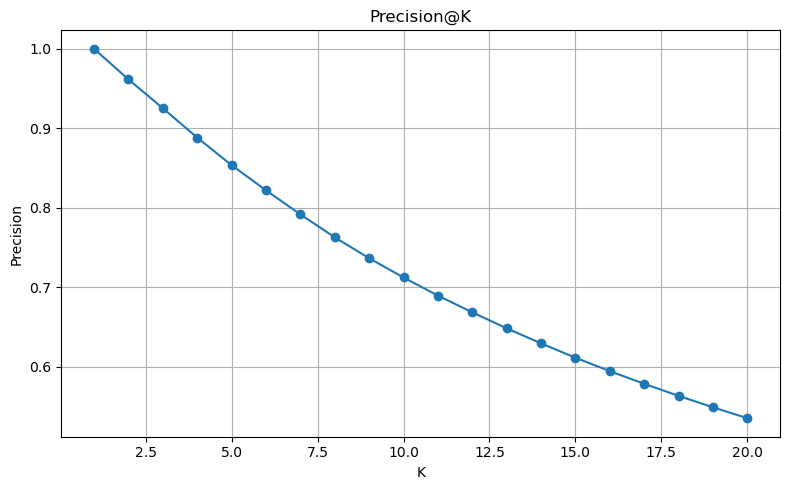

In [18]:
# Visualize precision@K

ks = list(range(1, 21))
precisions = [precision_at_k(test_preds, k=k) for k in ks]
plt.figure(figsize=(8, 5))
plt.plot(ks, precisions, marker='o')
plt.title("Precision@K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()